<a href="https://colab.research.google.com/github/unicamp-dl/IA025_2022S1/blob/main/ex06/Antonio_Angulo/Aula_6_Exerc%C3%ADcio_AntonioAngulo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Treinamento de uma CNN no CIFAR 10

In [3]:
nome = 'Antonio Lincoln Angulo Salas'

print(f'Meu nome é {nome}')

Meu nome é Antonio Lincoln Angulo Salas


Este exercicío consiste em implementar e treinar no CIFAR-10 vários blocos de uma Resnet seguido de uma camada linear de classificação.

## Importação das bibliotecas

In [4]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import random
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

## Fixando as seeds

In [5]:
random.seed(123)
np.random.seed(123)
torch.manual_seed(123)

## Dataset e dataloader

### Definição do tamanho do minibatch

In [6]:
batch_size = 50

## Download do CIFAR-10

In [7]:
!mkdir ./data

transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                             download=True, transform=transform)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                            download=True, transform=transform)


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## Criação do dataloader

In [8]:
train_size = 40000
val_size = 10000
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

In [9]:
batch_size = 50

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print('Número de minibatches de trenamento:', len(train_dataloader))
print('Número de minibatches de validação:', len(val_dataloader))
print('Número de minibatches de teste:', len(test_dataloader))

x_train, y_train = next(iter(train_dataloader))
print("\nDimensões dos dados de um minibatch:", x_train.size())
print("Valores mínimo e máximo dos pixels: ", torch.min(x_train), torch.max(x_train))
print("Tipo dos dados das imagens:         ", type(x_train))
print("Tipo das classes das imagens:       ", type(y_train))

Número de minibatches de trenamento: 800
Número de minibatches de validação: 200
Número de minibatches de teste: 200

Dimensões dos dados de um minibatch: torch.Size([50, 3, 32, 32])
Valores mínimo e máximo dos pixels:  tensor(-1.) tensor(1.)
Tipo dos dados das imagens:          <class 'torch.Tensor'>
Tipo das classes das imagens:        <class 'torch.Tensor'>


## Implementando o Bloco Básico da Resnet

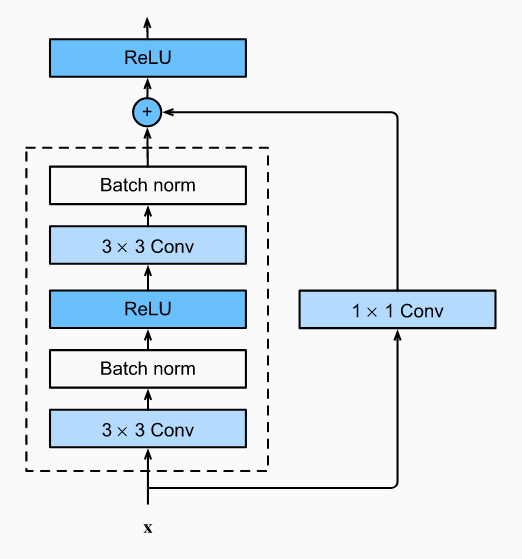

In [11]:
from torch import nn
from torch import Tensor


class MyBasicBlock(nn.Module):

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
    ) -> None:
        super().__init__()
        # Escreva seu código aqui.
        self.conv1 = nn.Conv2d(inplanes, planes, 3, stride, padding=(1,1), groups=1, bias=False, dilation=1)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(planes, planes, 3, 1, padding=(1,1), groups=1, bias=False, dilation=1)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = nn.Conv2d(inplanes, planes, 1, stride, padding=0, groups=1, bias=False, dilation=1)

    def forward(self, x: Tensor) -> Tensor:
        # Escreva seu código aqui.
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)        
        out = self.conv2(out)        
        out = self.bn2(out)
        out += self.downsample(x)
        out = self.relu(out)

        return out

## Compare se sua implementação está igual à do pytorch usando um exemplo aleatório

In [12]:
import torchvision

height_in = 5
width_in = 5
inplanes = 2
planes = 3
stride = 2

x = torch.rand(1, inplanes, height_in, width_in)

block = MyBasicBlock(inplanes=inplanes, planes=planes, stride=stride)

downsample = nn.Conv2d(inplanes, planes, kernel_size=1, stride=stride, padding=0, groups=1, bias=False, dilation=1)

block_pt = torchvision.models.resnet.BasicBlock(inplanes=inplanes, planes=planes, stride=stride, downsample=downsample)

# Usa os mesmos pesos para minha implementação e a do pytorch
block.load_state_dict(block_pt.state_dict())

out = block(x)
target_out = block_pt(x)

print(f'out:\n{out}')
print(f'target_out:\n{target_out}')

assert torch.allclose(out, target_out, atol=1e-6)

out:
tensor([[[[0.2084, 0.0000, 0.1053],
          [1.2176, 1.7145, 0.0000],
          [2.1509, 0.0000, 0.0000]],

         [[0.0000, 1.4478, 0.0000],
          [0.0000, 0.0000, 0.0000],
          [0.6579, 0.5231, 0.0000]],

         [[0.0000, 0.8983, 1.1205],
          [0.0000, 0.0000, 0.0225],
          [0.0000, 0.8017, 0.5681]]]], grad_fn=<ReluBackward0>)
target_out:
tensor([[[[0.2084, 0.0000, 0.1053],
          [1.2176, 1.7145, 0.0000],
          [2.1509, 0.0000, 0.0000]],

         [[0.0000, 1.4478, 0.0000],
          [0.0000, 0.0000, 0.0000],
          [0.6579, 0.5231, 0.0000]],

         [[0.0000, 0.8983, 1.1205],
          [0.0000, 0.0000, 0.0225],
          [0.0000, 0.8017, 0.5681]]]], grad_fn=<ReluBackward0>)


## Modelo

Implemente um modelo de classificação que será treinado no CIFAR-10.

In [13]:
class Net(torch.nn.Module):
    def __init__(self, ):
        super(Net, self).__init__()
        # Escreva seu código aqui.
        self.block1 = MyBasicBlock(inplanes=3, planes=64, stride=stride)
        self.block2 = MyBasicBlock(inplanes=64, planes=64, stride=stride)
        self.pooling = nn.AdaptiveAvgPool2d(1)
        self.linear_classifier = nn.Linear(64, 10)        

    def forward(self, x):
        # Escreva seu código aqui.
        x = self.block1(x)        
        x = self.block2(x)
        x = self.pooling(x).squeeze()
        out = self.linear_classifier(x)

        return out

## Treinamento

### Definição dos hiperparâmetros

In [14]:
n_epochs = 20
lr = 0.01

### Detectando a GPU

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [19]:
def evaluation(model, loader):
    # Escreva seu código aqui.
    y_hat = []
    mean_accuracy = 0.0
    acertos = 0.0
    total = 0.0
    
    for x, y in loader:
        x_eval = x.to(device)
        out = model(x_eval)
        
        y_softmax = torch.softmax(out, dim=1).cpu()
        y_hat = y_softmax.argmax(dim=1)
        acertos += y[y == y_hat].shape[0]
        total += 1 * x.shape[0]

    mean_accuracy = acertos / total
    
    print(f'Accuracy: {mean_accuracy}')

### Laço de treinamento

In [20]:
from tqdm import tqdm


model = Net()

model.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr)

epochs = []
loss_history = []
loss_epoch_end = []
total_trained_samples = 0

# Primeira avaliação com pesos aleatórios
evaluation(model=model, loader=val_dataloader)

for i in range(n_epochs):
    model.train()
    for x_train, y_train in tqdm(train_dataloader, total=len(train_dataloader), desc='Training'):
        x_train = x_train.to(device)
        y_train = y_train.to(device)

        # predict da rede
        outputs = model(x_train)

        # calcula a perda
        loss = criterion(outputs, y_train)

        # zero, backpropagation, ajusta parâmetros pelo gradiente descendente
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_trained_samples += x_train.size(0)
        epochs.append(total_trained_samples / len(train_dataset))
        loss_history.append(loss.item())

    loss_epoch_end.append(loss.item())
    print(f'Epoch: {i:d}/{n_epochs - 1:d} Loss: {loss.item()}')

    # Chama a função de validação no final de cada época
    evaluation(model=model, loader=val_dataloader)

Accuracy: 0.0981


Training: 100%|██████████| 800/800 [00:11<00:00, 68.06it/s]


Epoch: 0/19 Loss: 1.5104795694351196
Accuracy: 0.4085


Training: 100%|██████████| 800/800 [00:11<00:00, 68.04it/s]


Epoch: 1/19 Loss: 1.4906890392303467
Accuracy: 0.4789


Training: 100%|██████████| 800/800 [00:12<00:00, 65.18it/s]


Epoch: 2/19 Loss: 1.1951141357421875
Accuracy: 0.5235


Training: 100%|██████████| 800/800 [00:11<00:00, 67.21it/s]


Epoch: 3/19 Loss: 1.5023006200790405
Accuracy: 0.5633


Training: 100%|██████████| 800/800 [00:12<00:00, 66.39it/s]


Epoch: 4/19 Loss: 1.1329349279403687
Accuracy: 0.5824


Training: 100%|██████████| 800/800 [00:11<00:00, 68.72it/s]


Epoch: 5/19 Loss: 1.0362564325332642
Accuracy: 0.5916


Training: 100%|██████████| 800/800 [00:11<00:00, 67.25it/s]


Epoch: 6/19 Loss: 0.9680477976799011
Accuracy: 0.6223


Training: 100%|██████████| 800/800 [00:11<00:00, 67.91it/s]


Epoch: 7/19 Loss: 1.0605887174606323
Accuracy: 0.6364


Training: 100%|██████████| 800/800 [00:11<00:00, 67.49it/s]


Epoch: 8/19 Loss: 1.0501489639282227
Accuracy: 0.6417


Training: 100%|██████████| 800/800 [00:11<00:00, 68.00it/s]


Epoch: 9/19 Loss: 0.8369660377502441
Accuracy: 0.6535


Training: 100%|██████████| 800/800 [00:12<00:00, 66.46it/s]


Epoch: 10/19 Loss: 0.735319197177887
Accuracy: 0.6609


Training: 100%|██████████| 800/800 [00:11<00:00, 68.45it/s]


Epoch: 11/19 Loss: 1.0677616596221924
Accuracy: 0.6668


Training: 100%|██████████| 800/800 [00:11<00:00, 68.15it/s]


Epoch: 12/19 Loss: 0.8689367771148682
Accuracy: 0.6791


Training: 100%|██████████| 800/800 [00:12<00:00, 66.60it/s]


Epoch: 13/19 Loss: 0.8175058960914612
Accuracy: 0.6795


Training: 100%|██████████| 800/800 [00:11<00:00, 67.43it/s]


Epoch: 14/19 Loss: 0.5823299288749695
Accuracy: 0.6804


Training: 100%|██████████| 800/800 [00:11<00:00, 67.27it/s]


Epoch: 15/19 Loss: 1.0012006759643555
Accuracy: 0.6875


Training: 100%|██████████| 800/800 [00:11<00:00, 67.46it/s]


Epoch: 16/19 Loss: 0.7632288932800293
Accuracy: 0.6959


Training: 100%|██████████| 800/800 [00:12<00:00, 66.64it/s]


Epoch: 17/19 Loss: 0.7388983964920044
Accuracy: 0.6985


Training: 100%|██████████| 800/800 [00:11<00:00, 68.60it/s]


Epoch: 18/19 Loss: 0.7774972319602966
Accuracy: 0.708


Training: 100%|██████████| 800/800 [00:11<00:00, 66.71it/s]


Epoch: 19/19 Loss: 0.3713668882846832
Accuracy: 0.7001


### Visualização usual da perda, somente no final de cada minibatch

Text(0.5, 0, 'época')

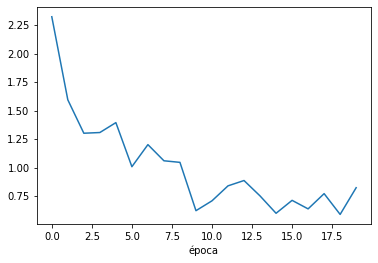

In [21]:
n_batches_train = len(train_dataloader)
plt.plot(epochs[::n_batches_train], loss_history[::n_batches_train])
plt.xlabel('época')

## Avaliação final no dataset de testes

In [22]:
evaluation(model=model, loader=test_dataloader)

Accuracy: 0.7052


# Bonus Opcional

## Implementando o Dropout

In [29]:
class MyDropout(torch.nn.Module):
    def __init__(self, p: float = 0.6):
        super(MyDropout, self).__init__()
        # Dropout probability has to be between 0 and 1
        self.p = p
    def __call__(self, x, training = True):
        self.x = x
        if training:
            #https://pytorch.org/docs/stable/generated/torch.nn.functional.dropout.html
            bernoulli = torch.distributions.bernoulli.Bernoulli(probs=(self.p))
            sample = bernoulli.sample(self.x.size())*(self.p)
            return self.x*sample
        else:
            return self.x

## Mostre que sua implementação traz resultados semelhantes à implementação do pytorch

In [30]:
import math

p = 0.5
dropout = MyDropout(p=p)

x = torch.rand(16, 3, 32, 32)

out = dropout(x, training=True)
out_pt = torch.nn.functional.dropout(x, p=p, training=True)

mean_zeros = (out == 0).sum() / out.numel()
mean_zeros_pt = (out_pt == 0).sum() / out_pt.numel()

print(f'mean zeros: {mean_zeros}')
print(f'mean zeros pytorch: {mean_zeros_pt}')

assert math.isclose(mean_zeros, mean_zeros_pt, abs_tol=1e-2)

out = dropout(x, training=False)
target_out = torch.nn.functional.dropout(x, p=p, training=False, inplace=False)
assert torch.allclose(out, target_out, atol=1e-6)

mean zeros: 0.4971720278263092
mean zeros pytorch: 0.5010172724723816
